In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

# Demo On Unseen Data: Gathering Data

In [ ]:
pitcher_data, batter_data = get_statcast_data('2021/Pitch-Arsenal-Pitchers-2021.csv', '2021/Pitch-Arsenal-Batters-2021.csv')
demo = get_pybaseball_data('2021-06-16', '2021-08-04', pitcher_data, batter_data)

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.63it/s]


In [ ]:
demo.head()

,game_id,game_date,game_year,home_team,away_team,pitcher_name,p_throws,pitcher_id,pitch_number,batter_name,...,p_slg,p_woba,p_whiff_percent,p_k_percent,b_run_value_per_100,b_ba,b_slg,b_woba,b_whiff_percent,b_k_percent
62085,633612,2021-06-16,2021,KC,DET,"Singer, Brady",R,663903,1,"Grossman, Robbie",...,0.406,0.364,21.4,20.1,-3.3,0.091,0.273,0.201,23.5,26.3
62291,633612,2021-06-16,2021,KC,DET,"Singer, Brady",R,663903,1,"Baddoo, Akil",...,0.406,0.364,21.4,20.1,1.9,0.231,0.385,0.345,33.9,21.9
376,633612,2021-06-16,2021,KC,DET,"Singer, Brady",R,663903,2,"Baddoo, Akil",...,0.425,0.330,31.9,29.6,2.5,0.364,0.455,0.396,34.5,27.0
62290,633612,2021-06-16,2021,KC,DET,"Singer, Brady",R,663903,3,"Baddoo, Akil",...,0.406,0.364,21.4,20.1,1.9,0.231,0.385,0.345,33.9,21.9
62289,633612,2021-06-16,2021,KC,DET,"Singer, Brady",R,663903,4,"Baddoo, Akil",...,0.406,0.364,21.4,20.1,1.9,0.231,0.385,0.345,33.9,21.9


# Demo On Unseen Data: Data Processing

In [ ]:
demo = demo.groupby('game_id').filter(lambda x : len(x) >= 200)

In [ ]:
demo = demo[demo['pitcher_id'] == 453286]
demo[['pitch_number', 'batter_id']].value_counts().tolist()[0]

###### DROP SOME COLUMNS FOR THE LAST TIME (SOME COLUMNS EXISTED PREVIOUSLY PURELY FOR SORTING PURPOSES))######

demo = demo.drop(['pitch_number','at_bat_number', 'pitcher_name', 'batter_name', 'game_year'], axis = 1)

# # DROP PITCH_NUMBER LATER

# ###### REORDER DATAFRAME INTO STATIONARY + SEQUENTIAL COLUMNS  (BASIC IDEA)--> [[STATIONARY COLUMNS], [SEQUENTIAL COLUMNS], [LABEL]] ######

demo = demo[['pitcher_id', 'batter_id', 'p_run_value_per_100', 'p_ba',
       'p_slg', 'p_woba', 'p_whiff_percent', 'p_k_percent',
       'b_run_value_per_100', 'b_ba', 'b_slg', 'b_woba', 'b_whiff_percent',
       'b_k_percent', 'game_id', 'home_team', 'away_team', 'inning', 'inning_topbot', 'outs_when_up', 'count',
       'on_3b', 'on_2b', 'on_1b','type', 'home_score', 'away_score',
       'post_home_score', 'post_away_score', 'pitch_type']]

In [ ]:
demo = demo[demo['pitcher_id'] == 453286]
demo = demo[['batter_id', 'p_run_value_per_100', 'p_ba',
       'p_slg', 'p_woba', 'p_whiff_percent', 'p_k_percent',
       'b_run_value_per_100', 'b_ba', 'b_slg', 'b_woba', 'b_whiff_percent',
       'b_k_percent', 'inning', 'inning_topbot', 'outs_when_up', 'count',
       'on_3b', 'on_2b', 'on_1b','type', 'pitch_type']]

In [ ]:
demo

,batter_id,p_run_value_per_100,p_ba,p_slg,p_woba,p_whiff_percent,p_k_percent,b_run_value_per_100,b_ba,b_slg,...,b_k_percent,inning,inning_topbot,outs_when_up,count,on_3b,on_2b,on_1b,type,pitch_type
50575,546318,-1.6,0.199,0.390,0.293,35.1,32.5,-0.2,0.328,0.483,...,21.9,1,Bot,0,0-0,0,0,0,B,4-Seamer
50574,546318,-1.6,0.199,0.390,0.293,35.1,32.5,-0.2,0.328,0.483,...,21.9,1,Bot,0,1-0,0,0,0,S,4-Seamer
131860,546318,-1.6,0.179,0.282,0.245,25.0,37.2,2.8,0.269,0.500,...,3.2,1,Bot,0,1-1,0,0,0,S,Cutter
133996,546318,-0.5,0.098,0.157,0.153,32.3,34.5,2.6,0.276,0.448,...,6.7,1,Bot,0,1-2,0,0,0,B,Changeup
55239,546318,1.2,0.333,0.542,0.388,45.0,36.0,-1.1,0.160,0.200,...,33.3,1,Bot,0,2-2,0,0,0,B,Curveball
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64454,676801,-1.8,0.147,0.293,0.217,46.3,41.0,2.2,0.192,0.500,...,39.3,7,Top,2,0-0,0,1,0,S,Slider
64453,676801,-1.8,0.147,0.293,0.217,46.3,41.0,2.2,0.192,0.500,...,39.3,7,Top,2,0-1,0,1,0,S,Slider
64452,676801,-1.8,0.147,0.293,0.217,46.3,41.0,2.2,0.192,0.500,...,39.3,7,Top,2,0-2,0,1,0,B,Slider
101208,676801,-1.6,0.199,0.390,0.293,35.1,32.5,-0.9,0.216,0.432,...,28.9,7,Top,2,1-2,0,1,0,S,4-Seamer


In [ ]:
demo = pd.get_dummies(demo)

In [ ]:
list_of_rows = []
df_list = []
        
for i in range(len(demo) - 1):
    curr_id = demo.iloc[[i]].values[0,0]
    next_id = demo.iloc[[i + 1]].values[0,0]
    
    if curr_id == next_id:
        temp_df = demo.iloc[[i]].values[0] # add loc here for columns
        list_of_rows.append(temp_df)
    
    if curr_id != next_id:
        temp_df = demo.iloc[[i]].values[0]
        list_of_rows.append(temp_df)
        df_list.append(pd.DataFrame(list_of_rows, columns = demo.columns))
        list_of_rows.clear()
    
    else:
        pass
        

df_list[0]

,batter_id,p_run_value_per_100,p_ba,p_slg,p_woba,p_whiff_percent,p_k_percent,b_run_value_per_100,b_ba,b_slg,...,count_3-1,count_3-2,type_B,type_S,type_X,pitch_type_4-Seamer,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Cutter,pitch_type_Slider
0,546318,-1.6,0.199,0.390,0.293,35.1,32.5,-0.2,0.328,0.483,...,0,0,1,0,0,1,0,0,0,0
1,546318,-1.6,0.199,0.390,0.293,35.1,32.5,-0.2,0.328,0.483,...,0,0,0,1,0,1,0,0,0,0
2,546318,-1.6,0.179,0.282,0.245,25.0,37.2,2.8,0.269,0.500,...,0,0,0,1,0,0,0,0,1,0
3,546318,-0.5,0.098,0.157,0.153,32.3,34.5,2.6,0.276,0.448,...,0,0,1,0,0,0,1,0,0,0
4,546318,1.2,0.333,0.542,0.388,45.0,36.0,-1.1,0.160,0.200,...,0,0,1,0,0,0,0,1,0,0
5,546318,-1.6,0.179,0.282,0.245,25.0,37.2,2.8,0.269,0.500,...,0,1,0,1,0,0,0,0,1,0
6,546318,-1.6,0.199,0.390,0.293,35.1,32.5,-0.2,0.328,0.483,...,0,1,0,1,0,1,0,0,0,0


In [ ]:
df_final = []

for df in df_list:
    df_length = df.shape[0]
    if df_length <= 1:
        continue
    for i in range(2,df_length+1):
        df_temp = df[:i]
        label = list(df_temp.iloc[i-1, 35:40])
        stationary = list(df_temp.iloc[i-1, 0:13])
        df_temp.drop(df_temp.columns[0:13], axis=1, inplace=True)
        df_temp.drop(df_temp.columns[35:40], axis=1, inplace=True)
        df_temp.reset_index(drop=True, inplace=True)
        df_final += [(df_temp[:i-1], stationary, label)]

C:\Users\Shahriyar\anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
pitch_tensors = []

for data in df_final:
    tens = data[0].values
    pitch_tensors += [(tens.astype(float), data[1], data[2])]
    
df_final_by_type = [[] for _ in range(len(pitch_tensors[0][2]))]

for row in pitch_tensors:
    max_idx = np.asarray(row[2]).argmax()
    df_final_by_type[max_idx] += [row]
    
# df_final_types_combined = []

# for row in df_final_by_type:
#     df_final_types_combined.extend(row)
    
# tensors_final = [[] for _ in range(9)]  # for some reason this is 9

# for row in df_final_types_combined:
#     idx = row[0].shape[0] - 1
#     tensors_final[idx] += [row]
    

In [ ]:

for row in df_final_by_type:
    print(len(row))

# df_final_by_type[1] *= 3
# df_final_by_type[2] *= 8
# df_final_by_type[3] *= 7
# df_final_by_type[4] *= 3


df_final_types_combined = []

for row in df_final_by_type:
    df_final_types_combined.extend(row)

202
68
26
28
84


202
68
26
28
84


Text(0, 0.5, 'Count')

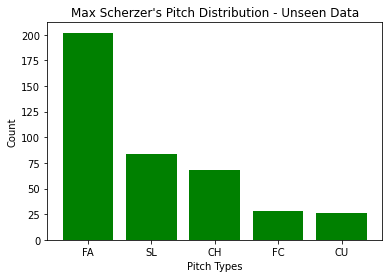

In [ ]:
for row in df_final_by_type:
    print(len(row))
    
plt.bar(['FA', 'SL', 'CH', 'FC', 'CU'],[202, 84, 68, 28, 26], color = 'Green')
plt.title("Max Scherzer's Pitch Distribution - Unseen Data")
plt.xlabel('Pitch Types')
plt.ylabel('Count')



In [ ]:
tensors_final = [[] for _ in range(9)]  # for some reason this is 8

for row in df_final_types_combined:
    idx = row[0].shape[0] - 1
    tensors_final[idx] += [row]

In [ ]:
for tensors in tensors_final:
    print('===================')
    print(len(tensors))

127
100
72
51
28
17
9
3
1


# Demo On Unseen Data: Loading Data

In [ ]:
demo_datasets = []

# Split 70:15:15

for data in tensors_final[0:9]:
    demo_datasets += [PitchDataset(data)]

In [ ]:
demo_dataloaders = []
batch_size = 1

for dataset in demo_datasets:
    demo_dataloaders += [DataLoader(dataset, shuffle=True, batch_size=batch_size)]

demo_data = MyLoader(demo_dataloaders)

# Demo On Unseen Data: Evaluation Of The GRU Model 

In [ ]:
model_loaded = FinalModel(hidden_size=27, num_classes=5)
model_path = get_model_name(model_loaded.name, batch_size=16, learning_rate=0.004, epoch=49)
state = torch.load(model_path)
model_loaded.load_state_dict(state)

print('Accuracy of Model for DEMO : {}'.format(get_accuracy(model_loaded, demo_data)))

Accuracy of Model for DEMO : 0.6666666666666666


# Demo On Unseen Data: Evaluation Of The Baseline Model

In [ ]:
ans, count = 0, 0
for i, grouping in enumerate(demo_data):
  for j, group in enumerate(grouping):
    temporal_data, stationary_data, labels = group
    for k in labels:
      if k.numpy() == 0:
        count+=1
      ans+=1
probability1 = count / ans
print(probability1)

#gives out 0.22833035029404244


0.3333333333333333


# Demo On Unseen Data: Confusion Matrix

In [ ]:
def get_accuracy_confusion_matrix(model, loader):
    true = []
    pred = []
    for batches in loader:
        for batch in batches:
            sequential, stationary, labels = batch
            labels = labels.type(torch.LongTensor)
            output = model(stationary.float(), sequential.float())
            #select index with maximum prediction score
            prediction = output.max(1, keepdim=True)[1]
            true += [labels.item()]
            pred += [prediction.item()]
    return true, pred

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('GnBu')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

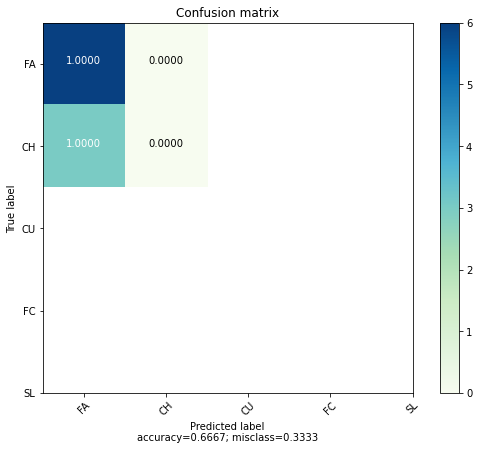

In [ ]:
true, pred = get_accuracy_confusion_matrix(model_loaded, demo_data)

import sklearn
from sklearn.metrics import confusion_matrix

demo_c = confusion_matrix(true, pred)
plot_confusion_matrix(demo_c, ['FA', 'CH', 'CU', 'FC', 'SL'])

# FA - 4-seamer
# CH - Changeup
# CU - Curveball
# FC - Cutter
# SL - Slider